In [2]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

In [3]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [4]:
## Using Decision Tree classifier to determine Neighborhood of crime

import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

In [5]:
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv")
incidents = incidents.dropna(axis='columns', how='all')
incidents = incidents.dropna()

# incidents.dtypes

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Set features & correct data type. This will also be used as your x values.

incidents['incidentDate'] = pd.to_datetime(incidents['incidentDate'])
incidents['precinct'] = incidents['precinct'].astype(str)
incidents['ucrCode'] = incidents['ucrCode'].astype(str)

incidents['incidentDate'] = pd.to_datetime(incidents['incidentDate'], format='%Y/%m/%d')
incidents['month']= incidents['incidentDate'].dt.month 
incidents['weekday'] =  incidents['incidentDate'].dt.dayofweek
incidents['day'] =  incidents['incidentDate'].dt.day

incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,weekday,day
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010-01-01,00:30,1,4,1
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010-01-01,01:05,1,4,1
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010-01-01,04:18,1,4,1
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010-01-01,03:00,1,4,1
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010-01-01,02:23,1,4,1


In [7]:
# Limit to data range to two years 2018 & 2019 

mask = (incidents['incidentDate'] > '2017-12-31') & (incidents['incidentDate'] < '2020-01-01')

incidents = incidents.loc[mask]
incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,weekday,day
169527,0004Xx 46 St E,MP2018066210,3,BURGB,Burglary Of Business,6.0,44.919705,-93.269608,Regina,2018-03-02,03:37,3,4,2
169528,0010Xx 8 St Se,MP2018068876,2,AUTOTH,Motor Vehicle Theft,8.0,44.986351,-93.237514,Marcy Holmes,2018-03-03,23:00,3,5,3
169529,0008Xx 13 Av Se,MP2018069260,2,TFMV,Theft From Motr Vehc,7.0,44.985314,-93.233748,Marcy Holmes,2018-03-04,02:00,3,6,4
169530,0002Xx Hennepin Av S,MP2018066884,1,SHOPLF,Shoplifting,7.0,44.982576,-93.268417,North Loop,2018-03-02,18:11,3,4,2
169531,0015Xx New Brighton Bl,MP2018069895,2,THEFT,Other Theft,7.0,45.003639,-93.228834,Northeast Park,2018-03-05,14:23,3,0,5


In [8]:
#Determime crime frequency by day for histograms

freq_day = incidents.groupby(['incidentDate']).count()
freq_neighborhood = incidents.groupby(['neighborhood']).agg(['count'])
freq_precinct = incidents.groupby(['precinct']).count() 
freq_offense = incidents.groupby(['offense']).count()

# freq_offense
# freq_neighborhood
# freq_precinct
# freq_day

Average Daily Frequency of Crime = 51.205479452054796


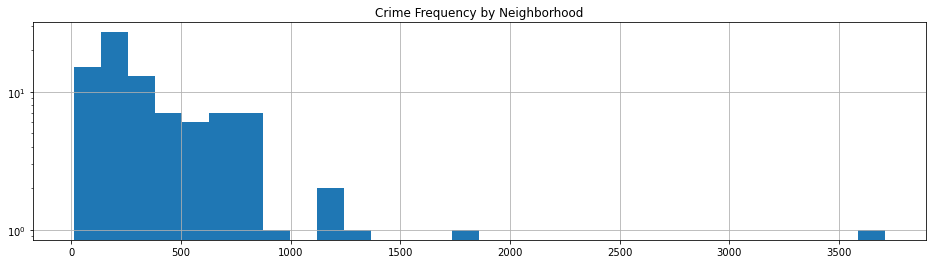

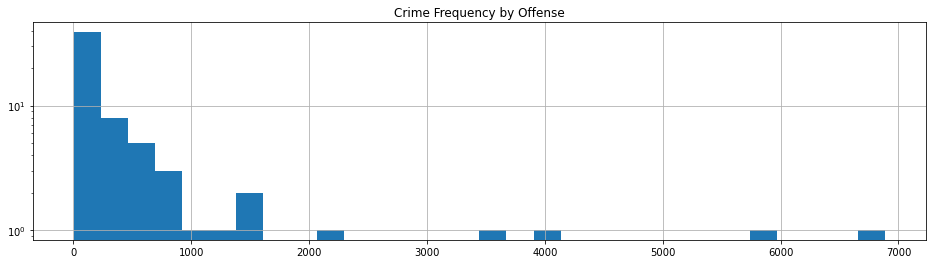

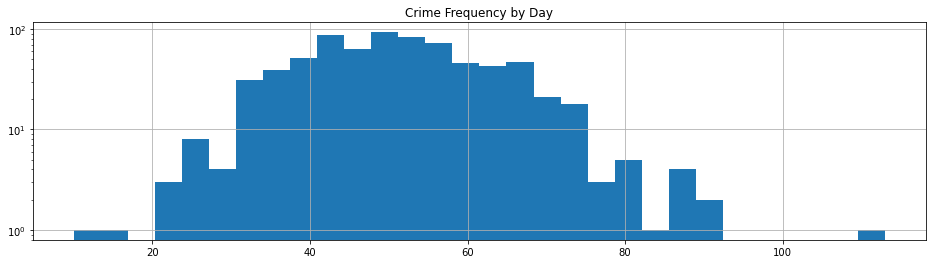

In [10]:
#Histograms by variables

print("Average Daily Frequency of Crime = {}"
      .format(np.average(freq_day)))

fig_1, (ax1) = plt.subplots(ncols=1, figsize=(16, 4))
ax1= freq_neighborhood['caseNumber'].hist(bins=30, log=True, ax=ax1)
plt.title("Crime Frequency by Neighborhood");
plt.savefig('images/Histo_Neighborhood.png')

fig_2, (ax2) = plt.subplots(ncols=1, figsize=(16, 4))
ax2= freq_offense['caseNumber'].hist(bins=30, log=True, ax=ax2)
plt.title("Crime Frequency by Offense");
plt.savefig('images/Histo_Offense.png')

fig_3, (ax0) = plt.subplots(ncols=1, figsize=(16, 4))
ax0 = freq_day['caseNumber'].hist(bins=30, log=True, ax=ax0)
plt.title("Crime Frequency by Day");
plt.savefig('images/Histo_Day.png')


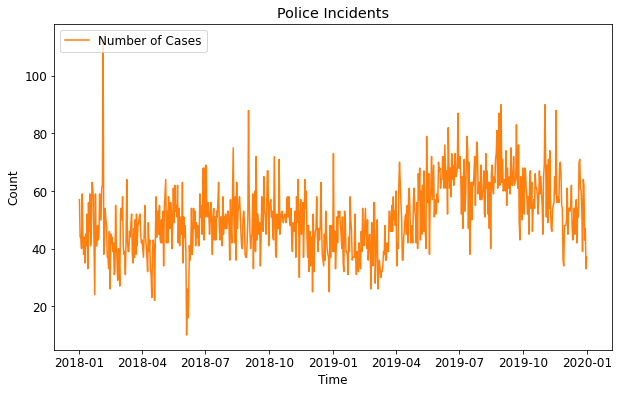

In [10]:
#run chart of crimes per day

plt.rc('font', size=12)
fig_4, ax = plt.subplots(figsize=(10, 6))

# Specify how our lines should look
ax.plot(freq_day.index, freq_day.caseNumber, color='tab:orange', label='Number of Cases')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('Count')
ax.set_title('Police Incidents')
ax.legend(loc='upper left');


In [11]:
X = incidents[['offense', 'precinct', 'ucrCode', 'month', 'weekday', 'day']]
y = incidents['neighborhood']

print(X.shape, y.shape)
# y

(37380, 6) (37380,)


In [12]:
# Spliting the data

from sklearn.model_selection import train_test_split

X = pd.get_dummies(X)
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# X_train.dtypes

In [13]:
# scaler the data set.  Poisson distribution requires non-negative numbers, so using MinMax Scaler

from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# print(y_test_scaled)
print(X_train_scaled.shape, y_train_scaled.shape)

(26166, 82) (26166, 88)


In [14]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(random_state=0)

rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.12100945247012662

In [15]:

predictions = rf.predict(X_test_scaled)
# print(predictions)

errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.');


Mean Absolute Error: Armatage          0.87
Audubon Park      1.71
Bancroft          1.39
Beltrami          0.48
Bottineau         1.14
                 ...  
West Calhoun      1.18
Whittier         10.21
Willard - Hay     4.58
Windom            1.98
Windom Park       1.69
Length: 88, dtype: float64 degrees.


In [16]:
print(f"Training Data Score: {rf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled, y_test)}")


Training Data Score: 0.5747152793701751
Testing Data Score: 0.12100945247012662


In [17]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day                  Importance: 0.39
Variable: month                Importance: 0.22
Variable: weekday              Importance: 0.16
Variable: precinct_1           Importance: 0.05
Variable: precinct_5           Importance: 0.03
Variable: precinct_2           Importance: 0.02
Variable: precinct_3           Importance: 0.02
Variable: precinct_4           Importance: 0.02
Variable: offense_SHOPLF       Importance: 0.01
Variable: offense_THEFT        Importance: 0.01
Variable: offense_ARSON        Importance: 0.0
Variable: offense_ARSON        Importance: 0.0
Variable: offense_ASLT1        Importance: 0.0
Variable: offense_ASLT1        Importance: 0.0
Variable: offense_ASLT2        Importance: 0.0
Variable: offense_ASLT2        Importance: 0.0
Variable: offense_ASLT3        Importance: 0.0
Variable: offense_ASLT3        Importance: 0.0
Variable: offense_ASLT4        Importance: 0.0
Variable: offense_ASLT4        Importance: 0.0
Variable: offense_AUTOTH       Importance: 0.0
Var

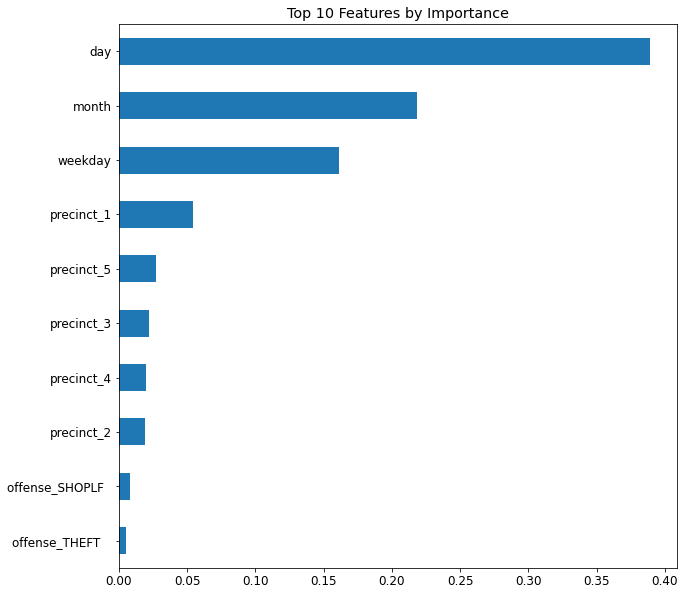

In [19]:
feature_sr = pd.Series(rf.feature_importances_, index=X.columns).\
    nlargest(10).\
    sort_values(ascending=True).\
    plot(kind='barh',title="Top 10 Features by Importance", figsize=(10, 10))

##feature_sr.plot().get_figure().savefig('../resources/rf_top_10_features.png')
plt.savefig('../resources/rf_top_10_features_model_1_fig_2.png')

In [20]:
#New random forest with top 10 most impactful variables to create new model.

from sklearn.ensemble import RandomForestRegressor

rf_most_important = RandomForestRegressor(n_estimators= 750, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('day'), feature_list.index('weekday'), feature_list.index('month'), feature_list.index('precinct_1'), feature_list.index('precinct_2'), feature_list.index('precinct_3'), feature_list.index('precinct_4'), feature_list.index('precinct_5'), feature_list.index('offense_SHOPLF'), feature_list.index('offense_THEFT')]
train_important = X_train_scaled[:, important_indices]
test_important = X_test_scaled[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / y_test))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: Armatage         0.01
Audubon Park     0.01
Bancroft         0.01
Beltrami         0.00
Bottineau        0.01
                 ... 
West Calhoun     0.01
Whittier         0.07
Willard - Hay    0.03
Windom           0.02
Windom Park      0.01
Length: 88, dtype: float64 degrees.
Accuracy: Armatage        -inf
Audubon Park    -inf
Bancroft        -inf
Beltrami        -inf
Bottineau       -inf
                ... 
West Calhoun    -inf
Whittier        -inf
Willard - Hay   -inf
Windom          -inf
Windom Park     -inf
Length: 88, dtype: float64 %.


In [29]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [750, 1000, 1250],
              'max_depth': [1, 10, 50],
              'criterion': ['gini', 'entropy']}
grid = GridSearchCV(rf, param_grid, verbose=3)

In [30]:
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time= 2.2min
[CV 2/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time= 2.2min
[CV 3/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time= 2.2min
[CV 4/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time= 2.2min
[CV 5/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time= 2.3min
[CV 1/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time= 3.0min
[CV 2/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time= 3.0min
[CV 3/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time= 3.0min
[CV 4/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time= 3.0min
[CV 5/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time= 3.0min
[CV 1/5] END .criterion=gini, max_depth=1, n_estimators=1250; total time= 3.7min
[CV 2/5] END .criterion=gini, max_depth=1, n_est

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 1/5] END criterion=gini, max_depth=50, n_estimators=1250; total time= 6.0min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 2/5] END criterion=gini, max_depth=50, n_estimators=1250; total time= 6.1min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 3/5] END criterion=gini, max_depth=50, n_estimators=1250; total time= 6.0min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 4/5] END criterion=gini, max_depth=50, n_estimators=1250; total time= 5.9min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 5/5] END criterion=gini, max_depth=50, n_estimators=1250; total time= 5.9min
[CV 1/5] END criterion=entropy, max_depth=1, n_estimators=750; total time= 1.7min
[CV 2/5] END criterion=entropy, max_depth=1, n_estimators=750; total time= 1.6min
[CV 3/5] END criterion=entropy, max_depth=1, n_estimators=750; total time= 1.6min
[CV 4/5] END criterion=entropy, max_depth=1, n_estimators=750; total time= 1.6min
[CV 5/5] END criterion=entropy, max_depth=1, n_estimators=750; total time= 1.6min
[CV 1/5] END criterion=entropy, max_depth=1, n_estimators=1000; total time= 2.2min
[CV 2/5] END criterion=entropy, max_depth=1, n_estimators=1000; total time= 2.2min
[CV 3/5] END criterion=entropy, max_depth=1, n_estimators=1000; total time= 2.2min
[CV 4/5] END criterion=entropy, max_depth=1, n_estimators=1000; total time= 2.2min
[CV 5/5] END criterion=entropy, max_depth=1, n_estimators=1000; total time= 2.2min
[CV 1/5] END criterion=entropy, max_depth=1, n_estimators=1250; total time= 2.7min
[CV 2/5] EN

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 1/5] END criterion=entropy, max_depth=50, n_estimators=1250; total time=10.8min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 2/5] END criterion=entropy, max_depth=50, n_estimators=1250; total time=11.1min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 3/5] END criterion=entropy, max_depth=50, n_estimators=1250; total time=11.0min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 4/5] END criterion=entropy, max_depth=50, n_estimators=1250; total time=10.1min


C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\sklearn\ensemble\_forest.py", line 393, in fit
    for i, t in enumerate(trees))
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 1044, in __call__
    while self.dispatch_one_batch(iterator):
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\joblib\parallel.py", line 777, in _

[CV 5/5] END criterion=entropy, max_depth=50, n_estimators=1250; total time= 7.6min


GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 50],
                         'n_estimators': [750, 1000, 1250]},
             verbose=3)

In [31]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 50, 'n_estimators': 1000}
0.12179943118393961


In [32]:
predictions_grid = grid.predict(X_test_scaled)

In [33]:
print(f"Testing Data Score using Optimized Model: {grid.score(X_test_scaled, y_test)}")

Testing Data Score using Optimized Model: 0.11699661137863385
